# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import warnings
warnings.filterwarnings("ignore")

import textblob
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn.decomposition import NMF, LatentDirichletAllocation as LDA
from sklearn.manifold import TSNE

import spacy
nlp = spacy.load('en_core_web_lg')

import seaborn as sns
import wordcloud
import pyLDAvis
from pyLDAvis import sklearn as sklearn_lda
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, LabelSet
import matplotlib.pyplot as plt
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Prepare Data

- Read in pre-processed data and do some additional cleaning of the condition and drug columns to remove extra punctuation. 
- Concatenate both the Drugs.com and Drugs Lib data so the specific drug and condition analysis is based on the maximum amount of data. 
- Combine the three different reviews of the Drugs Lib database into one to correspond with the structure of the Drugs.com dataset.
- Manipulate different ratings scores so they all match.
- To assist in finding generic drug names that correspond to a specific brand name I use a lookup table of all (registered) drugs from the FDA. The data can be downloaded from [this FDA website](https://www.fda.gov/drugs/drug-approvals-and-databases/drugsfda-data-files) and the specific table I use during the subsequent analysis is the 'Products' table. 

In [2]:
# Read in pre-cleaned reviews dataframes with standard sentiment ratings
with open('./reviews_with_sent_ratings.pk', 'rb') as f:
    df_com = pickle.load(f)
    df_lib = pickle.load(f)
    
# Read in drug lookup list
drugs = pd.read_csv('./data/drugs.txt', delimiter='\t', encoding = 'utf-8', error_bad_lines=False)

b'Skipping line 34958: expected 8 fields, saw 9\nSkipping line 34959: expected 8 fields, saw 9\nSkipping line 34960: expected 8 fields, saw 9\n'


In [3]:
# Combine all Drugs Lib reviews in single column
df_lib['all_reviews'] = df_lib['benefits_clean'] + df_lib['sideEffects_clean'] + df_lib['comments_clean']


# Concatenate Drugs Lib and Drugs Com dataframes
df_all = pd.DataFrame({'condition': df_com['condition'], 'drug': df_com['drugName'], 
                       'review': df_com['review_clean'], 'rating': df_com['rating'],
                       'sent_text': df_com['sent_text'], 'score_pol': df_com['score_pol'], 
                       'score_sub': df_com['score_sub']})

df_lib = df_lib.rename(columns={'urlDrugName': 'drug', 'all_reviews': 'review'})

df_all = pd.concat([df_all, df_lib[['condition', 'drug', 'review', 'rating', 
                                    'sent_text', 'score_pol', 'score_sub']]], sort=False)


# Clean drug names and condition columns to eliminate punctuation and lowercase
df_lib['drug'] = df_lib['drug'].str.replace('-', ' ').str.replace(' /', '').str.lower()
df_lib['condition'] = df_lib['condition'].str.replace('-', ' ').str.replace(' /', '').str.replace(',', '').str.lower()

drugs['DrugName'] = drugs['DrugName'].str.replace('-', ' ').str.replace(';', '').str.replace(',', '').str.lower()
drugs['ActiveIngredient'] = drugs['ActiveIngredient'].str.replace('-', ' ').str.replace(';', '').str.replace(',', '').str.lower()

df_all['drug'] = df_all['drug'].str.replace('-', ' ').str.replace(' /', '').str.lower()
df_all['condition'] = df_all['condition'].str.replace('-', ' ').str.replace(' /', '').str.replace(',', '').str.lower()


# Manipulate ratings so all match across datasets
def convert_rating(x):
    if x > 6:
        s = 3
    elif (x > 4) & (x < 7):
        s = 2
    else:
        s = 1
    return s

df_all['qual_rating'] = df_all['rating'].apply(convert_rating)
replace_map = {'sent_text': {'negative': 1, 'neutral': 2, 'positive': 3}}
df_all.replace(replace_map, inplace=True)

Import model and vectorizer used for classification of review ratings.

In [4]:
with open('clf_model.pkl', 'rb') as f:
    clf = pickle.load(f)
    vect = pickle.load(f)

# Inidividual Drug Analysis

The first step is to pick out a subset of reviews based on a single drug. From the lookup tables, we can combine both the generic drug name along with the brand name(s). The analysis gives the user the option to choose whether to match the exact spelling of the drug name or a partial string of the drug name. Also, the analysis offers the option to use only the chosen drug name, or both generic and and brand name version of the drug.

## Define Plotting Functions

In [5]:
def plot_rating(df, ax=None):
    all_ratings = list(range(1, 11))
    grp = df.groupby('rating')['rating'].count()
    ax.bar(grp.index, grp.values) 
    ax.set(title='Number of Reviews per Rating', xticks=all_ratings, xlabel=None)
    return ax

In [6]:
def plot_conditions(df, d_name, ax=None):
    grp = df.groupby('condition')['condition'].count().sort_values(ascending=False)
    if len(grp.index)>5:
        grp[:5].plot(ax=ax, kind='bar', rot=25)
        ax.set_title('Top 5 Conditions Treated by {0}'.format(d_name.upper()), fontsize=16)
    else:
        grp.plot(ax=ax, kind='bar', rot=25)
        ax.set_title('Conditions Treated by {0}'.format(d_name.upper()), fontsize=16)
    
    ax.set(xticklabels=grp.index, xlabel=None)
                     
    return ax

In [7]:
def make_wordcloud(df, d_name, ax=None):
    words = ' '.join(df['review'])
    wc = wordcloud.WordCloud(max_words=100, background_color="white").generate(words)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set(title='Wordcloud for {0}'.format(d_name.upper()))
    return ax

In [8]:
def pol_by_rating(df, ax=None):
    all_ratings = list(range(1, 11))
    grp = df.groupby('rating')['score_pol'].mean()
    ax.scatter(grp.index, grp.values)
    ax.set(title='Polarity by Rating', xticks=all_ratings, xlabel=None, ylabel='Polarity Value')
    return ax

In [9]:
# plot the distribution of sentiment: polarity and subjectivities
def plot_sent(df, ax=[]):
    ax1, ax2 = ax[0], ax[1]
    
    ax1.hist(df['score_pol'], facecolor='b', alpha=0.75)
    ax1.set(xlabel='Polarity Score', xlim=(-1.0,1.0), title='Polarity Distribution')
    # plotting mean code from here:https://stackoverflow.com/questions/16180946/drawing-average-line-in-histogram-matplotlib
    ax1.axvline(df['score_pol'].mean(), color='k', linestyle='dashed', linewidth=2) 
    ax1.text(0.75, 0.9, 'Mean: {:.2f}'.format(df['score_pol'].mean()), transform=ax1.transAxes, 
             bbox=dict(facecolor='red', alpha=0.25), fontsize=12)

    ax2.hist(df['score_sub'], facecolor='b', alpha=0.75)
    ax2.set(xlabel='Subjectivity Score', xlim=(0.0,1.0), title='Subjectivity Distribution')
    ax2.axvline(df['score_sub'].mean(), color='k', linestyle='dashed', linewidth=2)
    ax2.text(0.75, 0.9,'Mean: {:.2f}'.format(df['score_sub'].mean()), transform=ax2.transAxes,
            bbox=dict(facecolor='red', alpha=0.25), fontsize=12)

    return [ax1, ax2]

In [10]:
def plot_drug_data(df, d_name):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,15))

    plot_rating(df, ax1)
    plot_conditions(df, d_name, ax2)
    make_wordcloud(df, d_name, ax3)
    pol_by_rating(df, ax4)
    plot_sent(df, [ax5, ax6])

    plt.tight_layout()
    plt.show()
    
    return

In [11]:
def plot_sent_data(df, d_name):
    fig, ax = plt.subplots(figsize=(7,7))

    ax.hist(df['score_pol'], 30, normed=1, facecolor='b', alpha=0.75)
    ax.set(xlabel='Polarity Score', xlim=(-1.0,1.0), title='{0} Sentiment'.format(d_name.upper()))
    ax.axvline(df['score_pol'].mean(), color='k', linestyle='dashed', linewidth=2) 
    ax.text(0.75, 0.9, 'Mean: {:.2f}'.format(df['score_pol'].mean()), transform=ax.transAxes, 
             bbox=dict(facecolor='red', alpha=0.25), fontsize=12)
    plt.show()
    return 

In [12]:
def plot_bse_wcs(df, d_name):
    if len(df) > 0:
        print('Brand and generic benefits and side effects available for {0} reviews from Drugslib.com'.format(len(df)))

        fig, (ax0, ax1) = plt.subplots(1,2, figsize=(15,7))

        words = df['sideEffects_clean']
        wc = wordcloud.WordCloud(max_words=50, background_color="white").generate(str(words))
        ax0.imshow(wc, interpolation='bilinear')
        ax0.axis('off')
        ax0.set_title('{0} side effects'.format(d_name.upper()))

        words2 = df['benefits_clean']
        wc2 = wordcloud.WordCloud(max_words=50, background_color="white").generate(str(words2))
        ax1.imshow(wc2, interpolation='bilinear')
        ax1.axis('off')
        ax1.set_title('{0} benefits'.format(d_name.upper()))
    else:
        fig, ax = plt.subplots(figsize=(15,7))
        ax.text(0.5,0.5, 'No Benefits or Side Effects specific reviews to display', 
                verticalalignment='center', horizontalalignment='center',
                transform=ax.transAxes,
                color='blue', fontsize=24)
        ax.axis('off')

    plt.tight_layout
    plt.show()
    
    return

In [13]:
def show_drug_results(name, opt1, opt2, sents_only):
    d_name = name.lower()
    
    if opt2 == 0:
        generic_brand_set = drugs.loc[(drugs['DrugName'] == d_name) | (drugs['ActiveIngredient'] == d_name)]
    elif opt2 == 1:
        generic_brand_set = drugs.loc[(drugs['DrugName'].str.contains(d_name)) | (drugs['ActiveIngredient'].str.contains(d_name))]
    else:
        print('Incorrect option value entered. Can only be 0 or 1')
        
    if len(generic_brand_set)==0:
        print('No exact matches. Re-check spelling or try a partial drug name match option.')
    else:
        generic_brand_set_unique = generic_brand_set.groupby('DrugName')['DrugName'].count().index # individual brand names, without duplicates for different dosages
        new_lst = list(generic_brand_set_unique) + [generic_brand_set['ActiveIngredient'].iloc[0]]
        drug_lib_sub = df_lib.loc[df_lib['drug'].isin(new_lst)]

        if opt1 == 0:
            drug_sub = df_all.loc[df_all['drug'].isin(new_lst)]
            print('Below analysis based on {0} reviews for all brand name and generic.'.format(len(drug_sub)))
        elif opt1 == 1:   
            drug_sub = df_all.loc[df_all['drug'] == d_name]
            print('Below analysis based on {0} reviews for specified drug.'.format(len(drug_sub)))
        else: 
            print('Incorrect option value entered. Can only be 0 or 1')

        if (opt1==1) | (opt1==0):
            print('Drug Requested: {0} \nBrand Name(s): {1} \nGeneric Name: {2}'.format(d_name, list(generic_brand_set_unique), generic_brand_set['ActiveIngredient'].iloc[0]))
            if (sents_only == 0):
                plot_drug_data(drug_sub, d_name)
                plot_bse_wcs(drug_lib_sub, d_name)
            elif (sents_only == 1):
                plot_sent_data(drug_sub, d_name)
            else:
                print('Incorrect option value entered. Can only be 0 or 1')
                
            del drug_sub, drug_lib_sub
        else:
            print('Please re-enter option code.')
        
    return

## Generic EDA Analysis

The below charts show the distribution of actual user ratings for the drug, the conditions treated, a generic word cloud of all the reviews, a polarity score by rating, and finally sentiment polarity and subjectivity scores. Also, if the drug is present in the Drugslib.com dataset, there are wordclouds of side effect and benefits specific reviews.

The below code can quickly show the same plots for any drug name requested. I chose to display three of the top used drugs found during the EDA portion of this project; Phentermine is a drug used for weight loss, Nexplanon is a drug used for birth control and Miconazole is a drug used to treat yeast infections.

Below analysis based on 2883 reviews for specified drug.
Drug Requested: nexplanon 
Brand Name(s): ['nexplanon'] 
Generic Name: etonogestrel


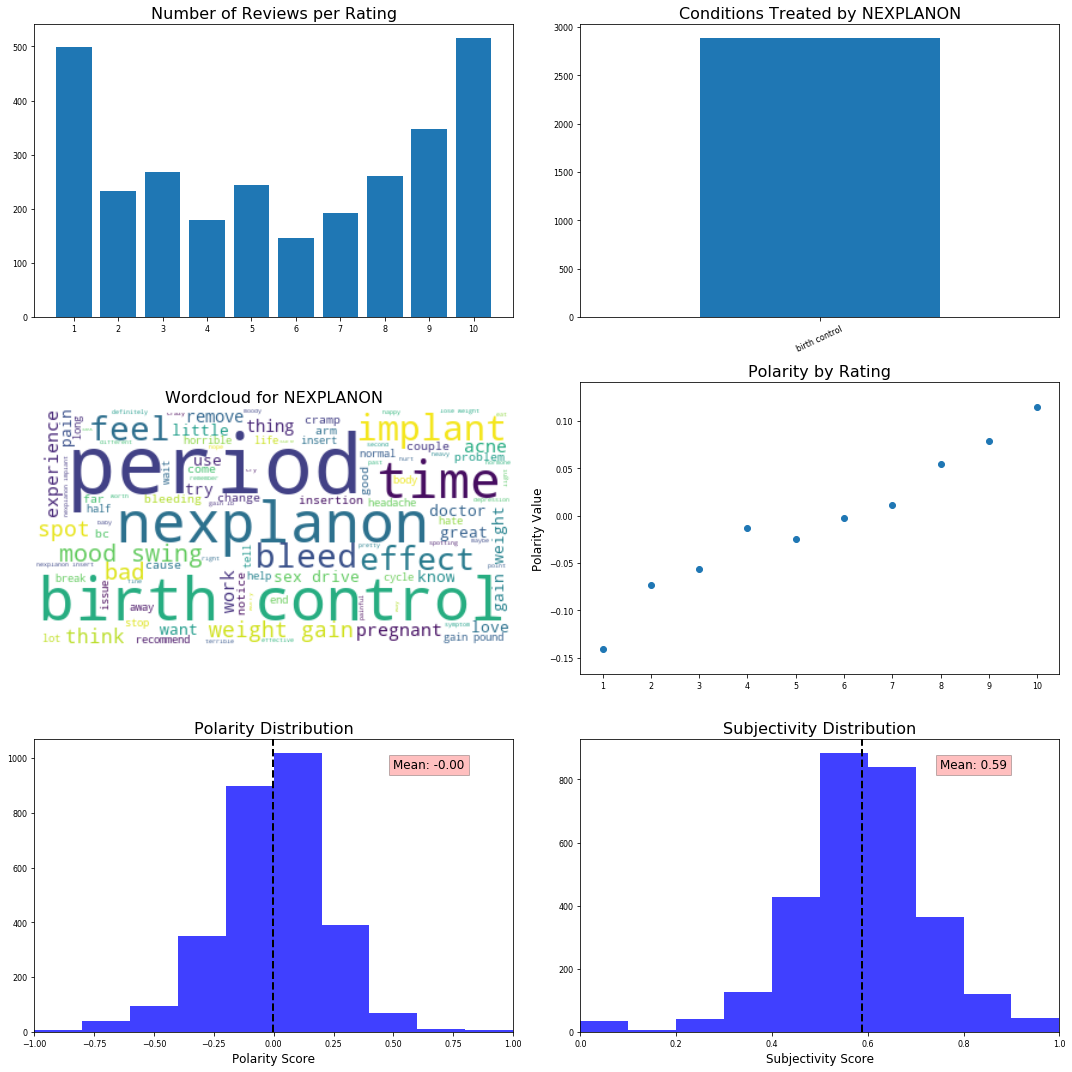

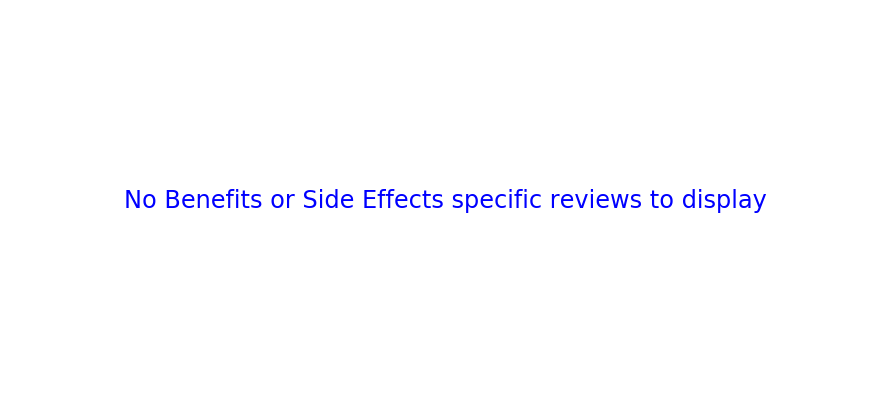

Below analysis based on 2077 reviews for specified drug.
Drug Requested: phentermine 
Brand Name(s): ['adipex p', 'fastin', 'ionamin', 'lomaira', 'obestin 30', 'oby trim', 'ona mast', 'phentermine hydrochloride', 'phentermine resin 30', 'phentermine resin complex', 'pre sate', 'qsymia', 'suprenza', 'tora', 'wilpo', 'wyamine sulfate'] 
Generic Name: mephentermine sulfate


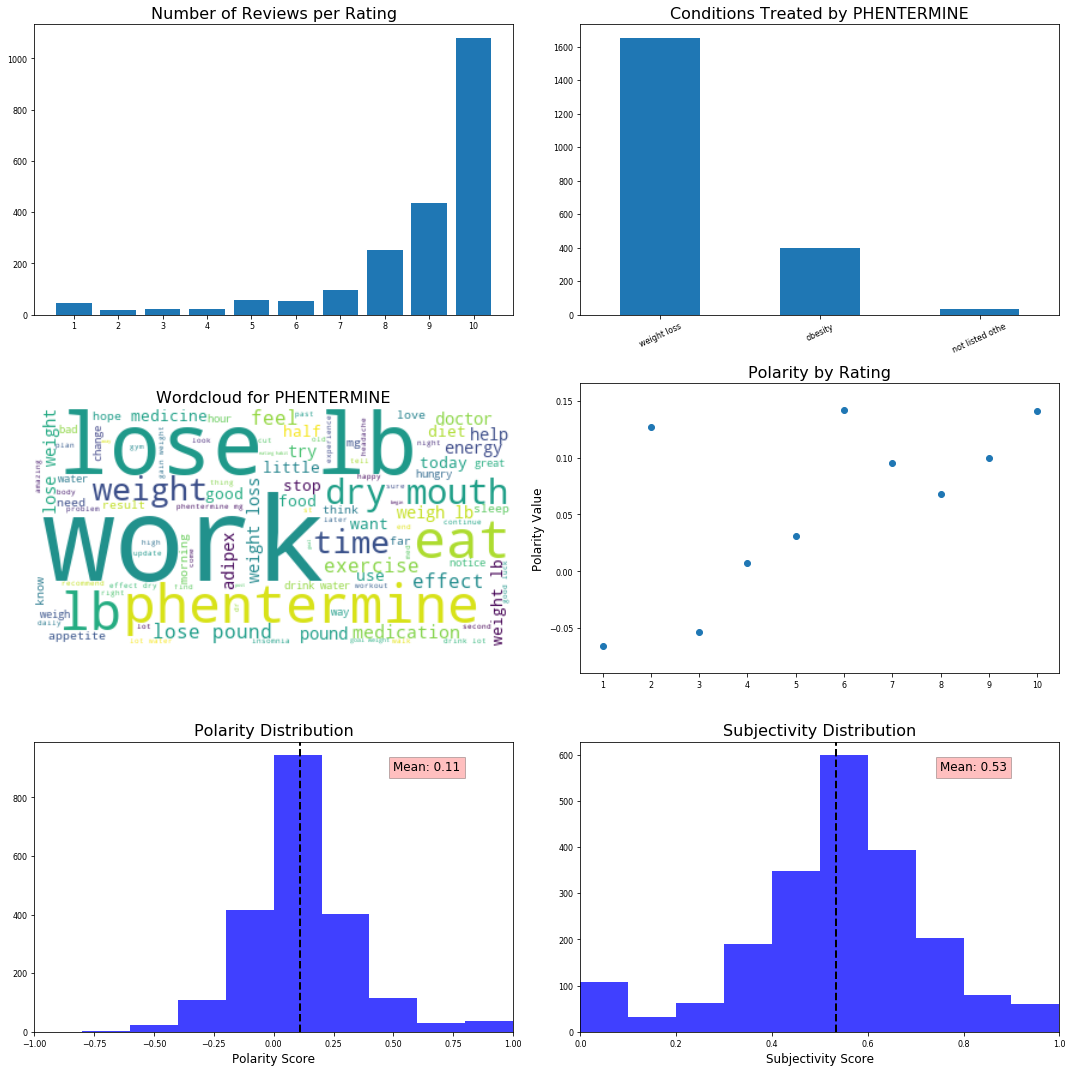

Brand and generic benefits and side effects available for 31 reviews from Drugslib.com


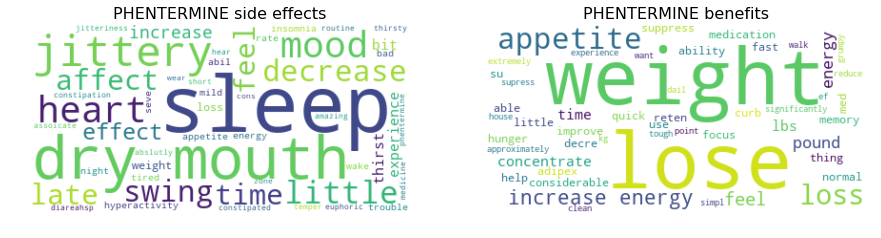

Below analysis based on 1341 reviews for specified drug.
Drug Requested: miconazole 
Brand Name(s): ['m zole 3 combination pack', 'm zole 7 dual pack', 'miconazole 3', 'miconazole 3 combination pack', 'miconazole 7', 'miconazole 7 combination pack', 'miconazole nitrate', 'miconazole nitrate combination pack', 'monistat', 'monistat 1 combination pack', 'monistat 3', 'monistat 3 combination pack', 'monistat 3 combination pack (prefilled)', 'monistat 5', 'monistat 7', 'monistat 7 combination pack', 'monistat derm', 'monistat dual  pak', 'oravig', 'vusion'] 
Generic Name: miconazole nitrate


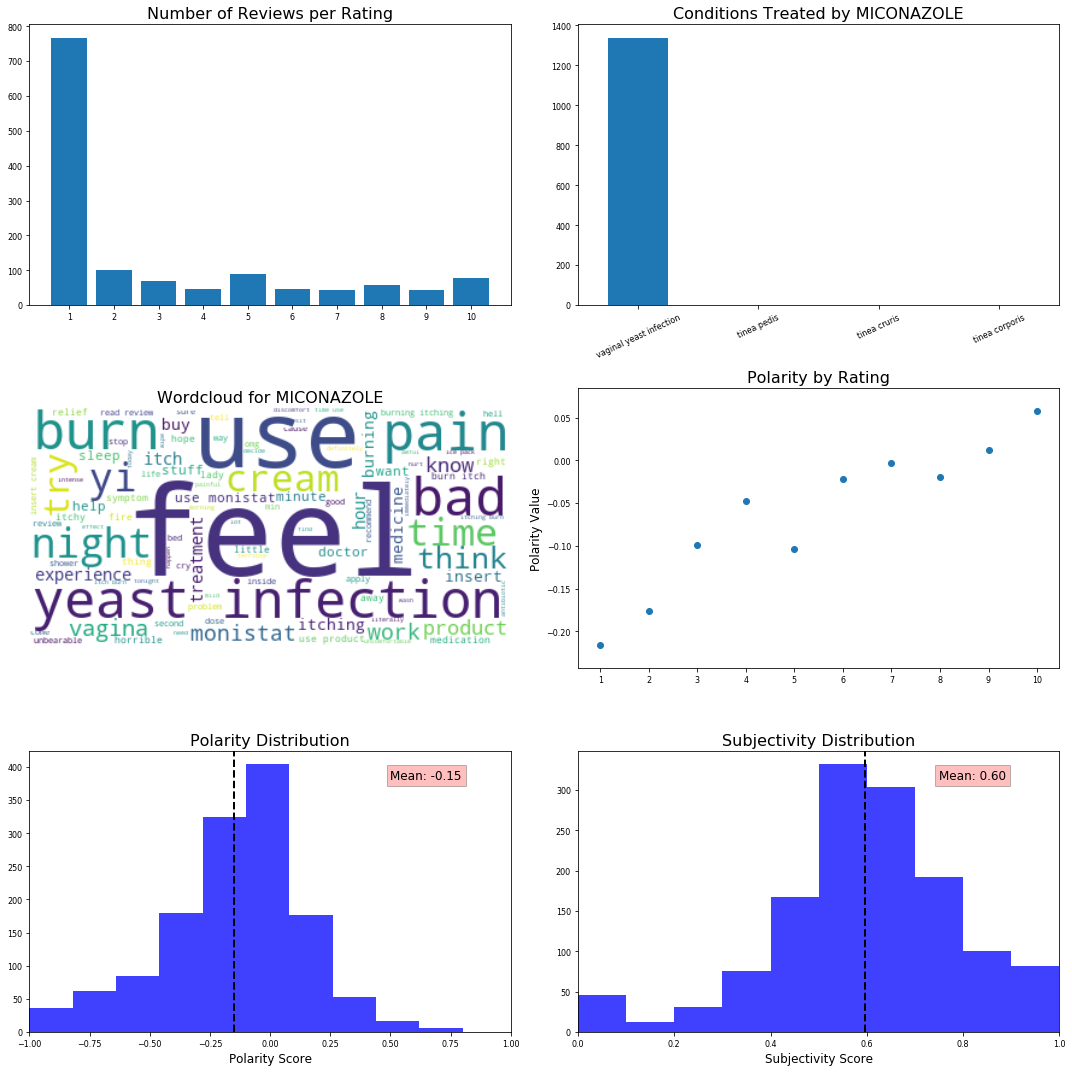

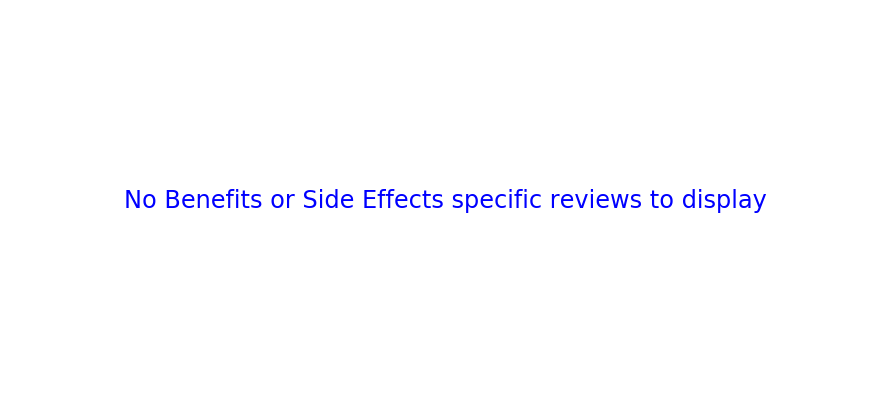

In [14]:
# type in a single drug name into the 'drug_name' variable and select options as described in the comments
drug_name = 'nexplanon'
generic_option = 1     #0 is all brand and generic values, 1 is only drug name entered
partial_option = 1     #0 is exact match, 1 is partial wording match
sentiment_option = 0   #0 is plot all graphs, 1 is plot only sentiment graph

show_drug_results(drug_name, generic_option, partial_option, sentiment_option)
show_drug_results('phentermine', generic_option, partial_option, sentiment_option)
show_drug_results('miconazole', generic_option, partial_option, sentiment_option)

The first set of charts is for the birth control medication, Nexplanon. The ratings were across the board with some people loving the drug and others hating it. This drug name is not specifically in the Drugslib.com dataset so there is not a side effects specific wordcloud to analyze. However, from the overall reviews wordcloud, we can interpret some of the words to indicate that side effects include, weight gain, affects on sex drive, mood swings, and bleeding. 

The next set of charts is for Phentermine. It is easy to see from the actual drug distribution of rating and the overall sentiment polarity score, that users are generally pleased with the drug. However, looking at the side effects, a new user to the drug would know to watch out for for things such as jitter, dry mouth and mood swings. 

Finally, Miconazole is a drug prescribe to treat yeast infections. The charts show that users overall really hate this drug. Again, there are no side effect specific reviews, but from the generic wordcloud the words itch and burn show up often which could indicate that these are side effects, or that the drug just failed to treat the condition at all.

## Sentiment vs. Classification Analysis

To further investigate a specific drug, I might try to segment out the reviews that are bad as opposed to the ones that are good. The bad reviews will be the ones most likely to lead reasearchers to fixing the issues and developing a better drug or help doctors develop a better treatment plan. 

Since all the data may not be annotated when scraping reviews, I show how my classification model predicts negative ratings compared to the actual user review for this annotated set and against a standard sentiment analysis.

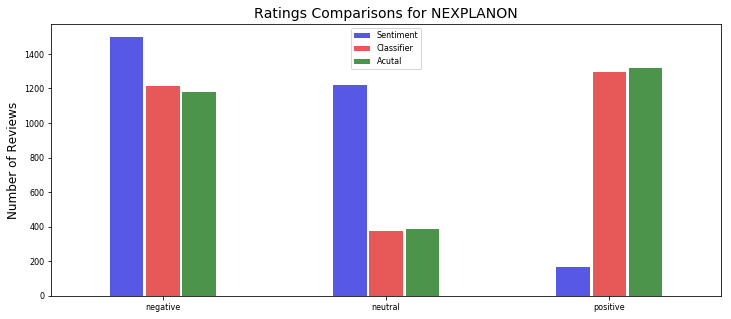

In [15]:
# create subset of data based on input drug
drug_subset = df_all.loc[(df_all['drug'].str.lower() == drug_name)]

# fit features and make predictions on subset using classifier model
drug_subset_feats = vect.transform(drug_subset['review'])
drug_subset['predicted_rating'] = clf.predict(drug_subset_feats)

# plot to compare actual ratings, sentiment deduced ratings and classifier predicted ratings.
def change_width(ax, new_value, shift) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + shift * diff * 0.5)
    return 

fig, ax = plt.subplots(figsize=(12,5))
width = 0.15
order = ['negative', 'neutral', 'positive']
ax1 = sns.countplot(x='sent_text', data=drug_subset, label='Sentiment', ax=ax, color='blue', alpha=0.75)
change_width(ax1, width, 0.5)
ax2 = sns.countplot(x='predicted_rating', data=drug_subset, label='Classifier', ax=ax, color='red', alpha=0.75)
change_width(ax2, width, 1)
ax3 = sns.countplot(x='qual_rating', data=drug_subset, label='Acutal', ax=ax, color='green', alpha=0.75)
change_width(ax3, width, 1.5)
plt.title('Ratings Comparisons for {0}'.format(drug_name.upper()), fontsize=14)
ax.set_ylabel('Number of Reviews')
ax.set_xlabel(None)
plt.xticks(np.arange(3), ('negative', 'neutral', 'positive'))
ax.legend()
plt.show()

The ratings comparison plot shows that green (actual user reviews) and red (classifier predicted ratings) are fairly close, within a couple of reviews (mis-classifications) of each other. However, the blue bar which indicates a rating deduced using a sentiment analysis does not match the actual ratings at all. Just relying on the sentiment of the rating is not going to be good enough to actually pull out the reviews that need addressing.

## Analysis of Negative Reviews

To continue with research on the bad reviews, I pull out a subset of the drug reviews that are classified with a negative rating. I try a number of different techniques to try to understand if there are any general topics that these reviews explain.

### Extract Reviews

In [16]:
if (len(drug_subset[drug_subset['predicted_rating'] == 1])) == 0:
    print('No negative predictions for {0}'.format(drug_name))
else:
    neg_drug_sub = drug_subset[drug_subset['predicted_rating'] == 1].reset_index(drop=True)
    neg_feats = vect.transform(neg_drug_sub['review'])

    num_neg_left_out = len(drug_subset[(drug_subset['rating'] < 4.0) & (drug_subset['predicted_rating'] > 1)])
    num_pos_incl = (neg_drug_sub['rating'] < 4.0).value_counts().tolist()[1]

    print('Number of predicted negative reviews being analyzed: ', len(neg_drug_sub))
    print('Number of negative reviews left out of analysis due to mis-classification: ', num_neg_left_out)
    print('Number of positive reviews in negative subset due to mis-classification: ', num_pos_incl)

Number of predicted negative reviews being analyzed:  1213
Number of negative reviews left out of analysis due to mis-classification:  10
Number of positive reviews in negative subset due to mis-classification:  225


### Similarity Scores

First, I get a general look to see if the negative reviews are similar to each other. If the reviews are generally similar then I might have a better chance at extracting some general topics. Users might be experiencing similar side effects and writing about them. 

Also, I do a quick check to make sure that no duplicate reviews end up in the dataset that could skew the analysis. Duplicate reviews may be from 'bots entering false data, a user copying their exact same review from one source to another, or some accident by the user or through the review software that makes the text show up two separate times. 

To find the similarity of each review I use the spaCy similarity function which is based on the cosine similarity algorithm. Each review is compared to every other review a single time giving a total of 'n_reviews choose 2' total similarity scores.

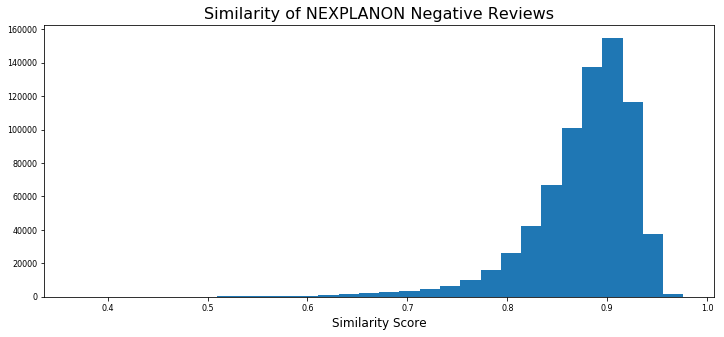

Number of duplicate reviews:  0


In [17]:
docs = neg_drug_sub['review'].apply(nlp)
sim_lst = []
d1_lst = []
d2_lst = []

for i, d1 in docs.items():
    for j, d2 in docs.iloc[i+1:].items():
        sim_lst.append(d1.similarity(d2))
        d1_lst.append(d1)
        d2_lst.append(d2)
        
df_sim = pd.DataFrame({'Review1':d1_lst, 'Review2':d2_lst, 'Similarity':sim_lst})

fig, ax = plt.subplots(figsize=(12,5))
ax.hist(df_sim['Similarity'], bins=30)
ax.set(title='Similarity of {0} Negative Reviews'.format(drug_name.upper()), xlabel='Similarity Score')
plt.savefig('similarities_{0}.png'.format(drug_name))
plt.show()

num_duplicates = len(df_sim[df_sim['Similarity']>0.99])
print('Number of duplicate reviews: ', num_duplicates)

### Wordcloud

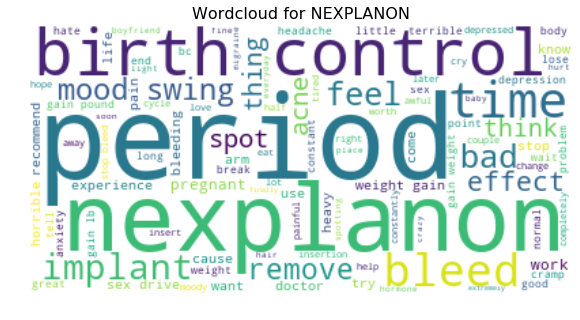

In [18]:
fig, ax = plt.subplots(figsize=(12,5))
make_wordcloud(neg_drug_sub, drug_name, ax)
plt.show()

Some things that jump out from the above wordcloud are expected words like the condition ('birth control'), and the name of the drug ('nexplanon') being analyzed. Other more interesting words that should provoke some further research to see if they are common side effects are 'bleed', 'spot', 'heavy', 'period' for how a woman's menstruation cycle is affected or 'mood swing', 'anxiety' to see how the drug affects the woman's mental state.

### Topic Modeling

One way to uncover specific themes or side effects for a specific drug is to perform topic modeling on the negative subset of reviews. Two different algorithms for topic modeling are Latent Dirichlet Allocation (LDA) and Non-negative Matrix Factorization (NMF). "[B]oth algorithms are able to return the documents that belong to a topic in a corpus and the words that belong to a topic. LDA is based on probabilistic graphical modeling while NMF relies on linear algebra ([topic modeling with scikit-learn](https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730))."

In [19]:
# code follows from:
# https://scikit-learn.org/stable/auto_examples/applications/...
# plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

number_topics = 5
number_words = 6
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1).fit(neg_feats)
lda_vis = sklearn_lda.prepare(lda, neg_feats, vect)

nmf = NMF(n_components=number_topics, random_state=42,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(neg_feats)
nmf_vis = sklearn_lda.prepare(nmf, neg_feats, vect)

A really great package that prepares a visualization to understand the topic modeling for LDA is pyLDAvis. An example with explanation of the results can be found [here](https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb#topic=0&lambda=1&term=). Each topic is given a circle size to indicate the ... 

In [20]:
def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % (topic_idx+1))
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

print("Topics found via LDA:")
print_topics(lda, vect, number_words)
pyLDAvis.display(lda_vis)

print("Topics found via NMF:")
print_topics(nmf, vect, number_words)
pyLDAvis.display(nmf_vis)

Topics found via LDA:

Topic #1:
nexplanon period bleed gain remove implant

Topic #2:
nexplanon period implant bleed birth birth control

Topic #3:
nexplanon bleed period implant remove birth

Topic #4:
nexplanon bleed period remove gain implant

Topic #5:
nexplanon period bleed implant remove gain
Topics found via NMF:

Topic #1:
period nexplanon bad like time mood

Topic #2:
bleed stop nexplanon bleeding time remove

Topic #3:
birth control birth control bleed bad sex

Topic #4:
implant remove gain weight time mood

Topic #5:
gain weight weight gain pound lbs mood


### K-Means Clustering

In LDA/NMF the number of topics could loosly be considered as a number of distinct clusters. However, in topic modeling, the results are probabilistic which relates to a a review's proportion of cluster/topic membership. In a sense, it can be referred to as 'soft' or 'fuzzy' clustering. On the other hand, formal clustering methods such as K-Means is a form of 'hard' clustering where a review can only be part of a single cluster, rather than many. 

To see if the results of the topic modeling are consistent, below I use K-Means to pick out the same number of clusters/topics as above to try to further understand the negative reviews and see if the side effects are the same.

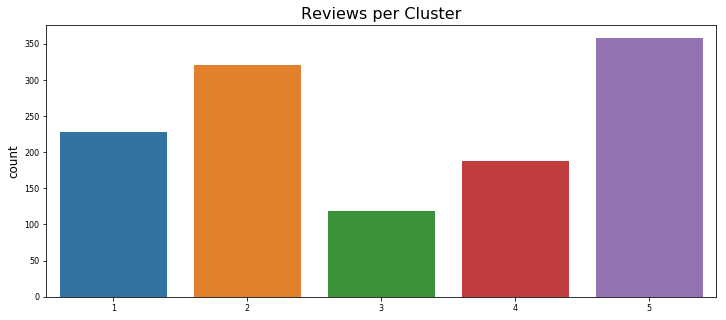

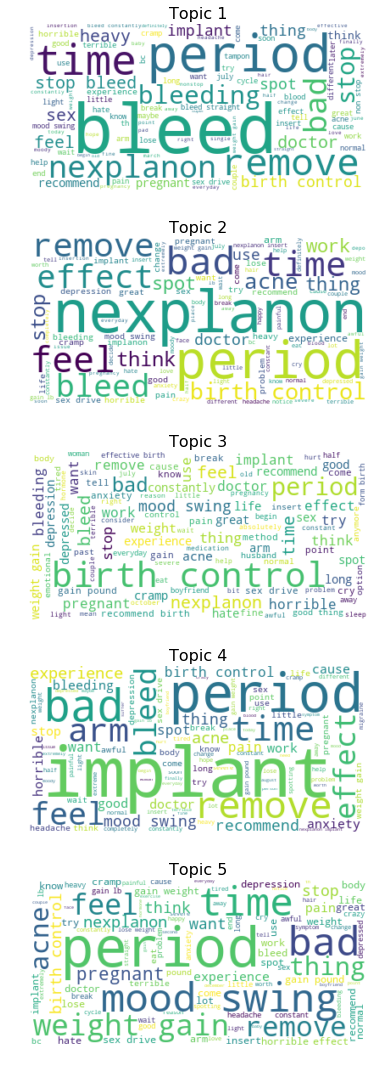

In [21]:
# fit K-Means method
KM_labels = KMeans(n_clusters=number_topics, random_state=42, n_jobs=-1).fit_predict(neg_feats)

# plot counts of reviews per fitted cluster
fig, ax = plt.subplots(figsize=(12,5))
g = sns.countplot(KM_labels) 
g.set(xticklabels=[1, 2, 3, 4, 5])
plt.title("Reviews per Cluster")
plt.show()

# plot wordclous related to reviews in each cluster
fig, ax = plt.subplots(5,1, figsize=(12,15))
for i in range(0,5):
    cluster_reviews = neg_drug_sub[KM_labels == i]
    make_wordcloud(cluster_reviews, drug_name, ax[i])
    ax[i].set(title='Topic {0}'.format(i+1))
plt.tight_layout()
plt.show()

### Word Vectors for Similar Side Effect Words

Finally we can transform the negative drug reviews into vectors using the spaCy package. The benefit of using vectors as features over count frequencies or TFIDF features is that spaCy vectors, very similar to word2vec vectors, are very close to each other for related words. For example, 'white' may have a very close vector to the 'beige' or 'cream' vectors, but be very far away from the vectors which describe 'planet' or 'dog'. 

The following code vectorizes each unique word in the negative drug reviews subset. The word vectors are then transformed from high dimensional words into a two dimensional vector using the t-SNE (t-distributed Stochastic Neighbor Embedding) algorithm from the sklearn library. These two dimensional values are then plotted in a graph with their corresponding word. 

In [25]:
# vectorize unique review words using spaCy
unique_words = set(neg_drug_sub['review'].str.cat(sep=' ').split(' ')) # set gets only the unique items in the list
unique_str =  ' '.join(word for word in unique_words)
docs = nlp(unique_str)

output_notebook()
# plot words on scatter plot
# code follows from: https://nlpforhackers.io/word-embeddings/
X = []
vocab = []

for token in docs:
    vocab.append(token.text)
    X.append(token.vector)
    
X = np.array(X)
X_embedded = TSNE(n_components=2, n_iter=250, verbose=2).fit_transform(X)
df = pd.DataFrame(columns=['x', 'y', 'word'])
df['x'], df['y'], df['word'] = X_embedded[:,0], X_embedded[:,1], vocab
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="word", y_offset=8, text_font_size="8pt", text_color="#555555", source=source, text_align='center')
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3366 samples in 0.065s...
[t-SNE] Computed neighbors for 3366 samples in 6.344s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3366
[t-SNE] Computed conditional probabilities for sample 2000 / 3366
[t-SNE] Computed conditional probabilities for sample 3000 / 3366
[t-SNE] Computed conditional probabilities for sample 3366 / 3366
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.396s
[t-SNE] Iteration 50: error = 88.4026718, gradient norm = 0.2059909 (50 iterations in 5.126s)
[t-SNE] Iteration 100: error = 89.7841110, gradient norm = 0.1863904 (50 iterations in 5.139s)
[t-SNE] Iteration 150: error = 90.6020889, gradient norm = 0.1757505 (50 iterations in 4.443s)
[t-SNE] Iteration 200: error = 89.7967224, gradient norm = 0.2061312 (50 iterations in 4.735s)
[t-SNE] Iteration 250: error = 90.3025436, gradient norm = 0.1674016 (50 iterations in 4.377s)
[t-SNE] KL divergence after 250 iterati

The above plot allows for scrolling and moving to zoom in on related words that show up in the negative drug reviews subset. Although the above data just shows all of the words (rather than the frequencies to indicate importance of the word), some concerning things that show up. Similar words like 'hospitalise', 'hysterectomy', 'ectopic', 'pregnancy', and 'implantation' are all incredibly concerning when analyzing a birth control drug. Even if these words may not show up as the most commonly used, the reviews in which they are located should absolutely be looked at because the severity of this side effect is much greater than something more common like 'acne' or 'weight gain'.

# Condition Analysis

The next step is to pull out a subset of conditions and look at the associated drugs. The graphs will be the same as the above specific drug analysis, but one can now compare them side-by-side when looking at a drug to choose based on the condition tyring to be treated.

## Define Plotting Functions

In [23]:
def condition_plots(condition_name, opt, top_n, opt2):          
    if (opt == 0):
        cond_sub = df_all.loc[df_all['condition']==condition_name]
        print('Total reviews found for condition: {0} \nNumber unique drugs prescribed: {1}'.format(len(cond_sub), cond_sub['drug'].nunique()))
    elif (opt == 1):
        cond_sub = df_all.loc[df_all['condition'].str.contains(condition_name)]
        print('Total reviews found for condition: {0} \nNumber unique drugs prescribed: {1}'.format(len(cond_sub), cond_sub['drug'].nunique()))
    else: print('Incorrect option value entered. Can only be 0 or 1')

    cond_topn = cond_sub.groupby('drug')['condition'].count().sort_values(ascending=False)[:top_n]
    print('Top {0} drugs used for {1}: {2}'.format(top_n, condition_name, list(cond_topn.index)))          
    for i in cond_topn.index:
        show_drug_results(i, 0, 1, opt2)
    return

## Run Analysis

When running this analysis there are three different options to choose. The first is to do an exact or partial word match of the condition name, the second option is to select how many of the top drugs the user wants to have displayed. Finally, the third option indicates if the user wants to see all of the charts, or only display the sentiment polartiy graphs for a quicker review.

Total reviews found for condition: 12769 
Number unique drugs prescribed: 131
Top 5 drugs used for depression: ['bupropion', 'sertraline', 'venlafaxine', 'desvenlafaxine', 'pristiq']
Below analysis based on 2146 reviews for all brand name and generic.
Drug Requested: bupropion 
Brand Name(s): ['aplenzin', 'bupropion hydrobromide', 'bupropion hydrochloride', 'contrave', 'forfivo xl', 'wellbutrin', 'wellbutrin sr', 'wellbutrin xl', 'zyban'] 
Generic Name: bupropion hydrochloride


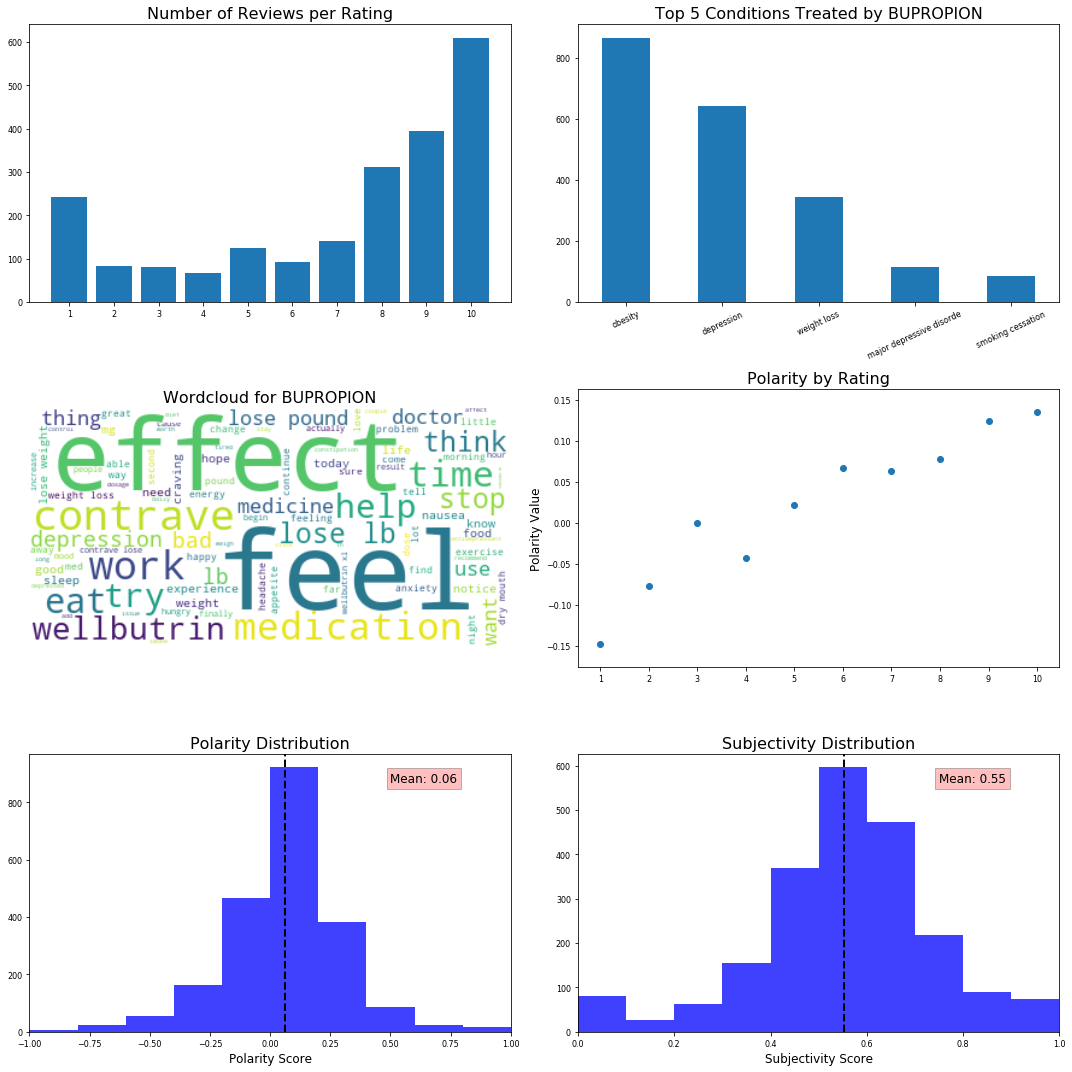

Brand and generic benefits and side effects available for 104 reviews from Drugslib.com


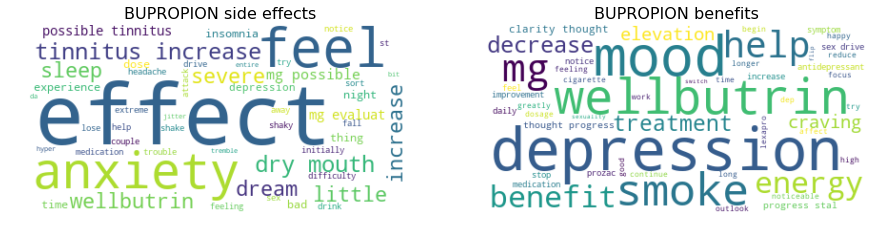

Below analysis based on 1129 reviews for all brand name and generic.
Drug Requested: sertraline 
Brand Name(s): ['sertraline hydrochloride', 'zoloft'] 
Generic Name: sertraline hydrochloride


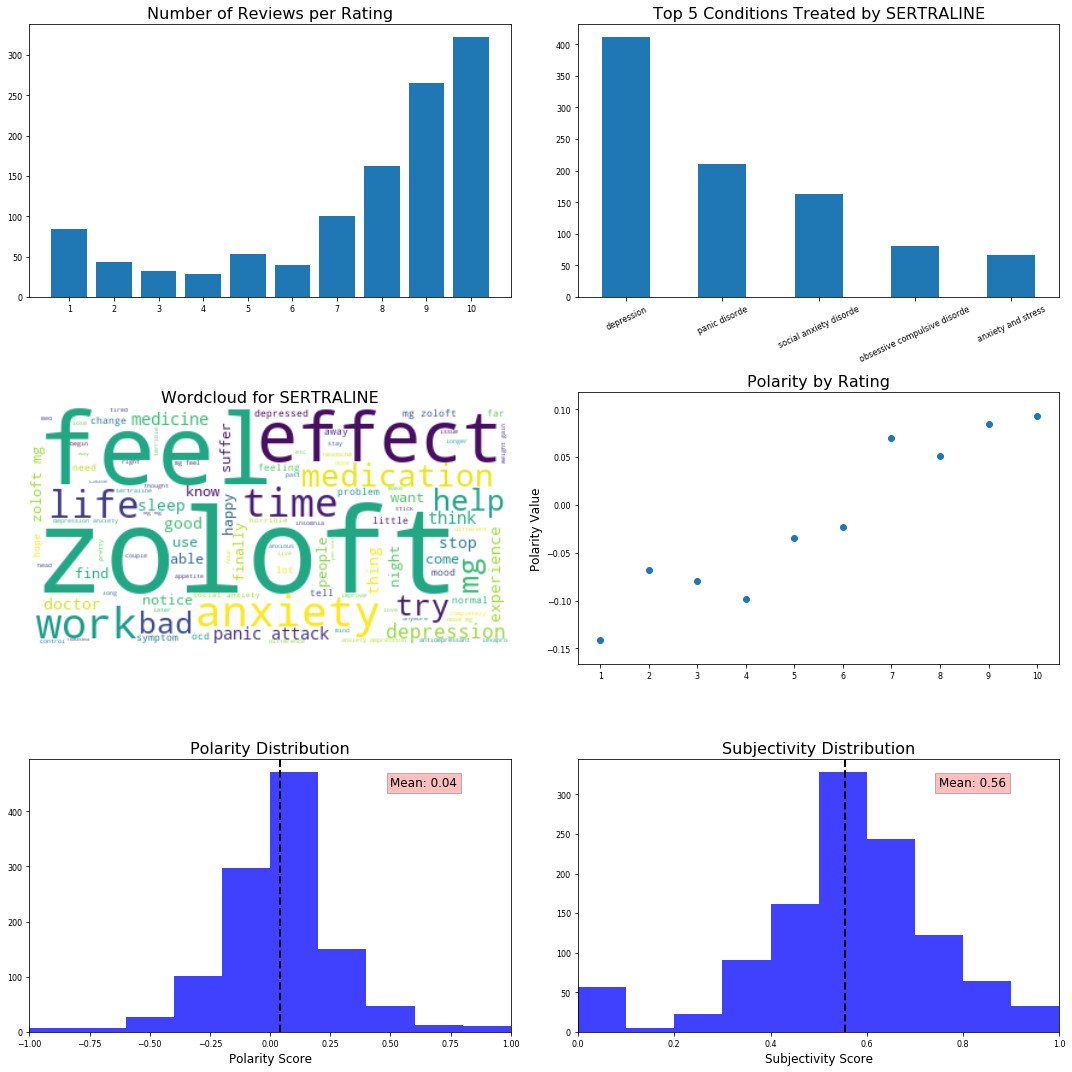

Brand and generic benefits and side effects available for 52 reviews from Drugslib.com


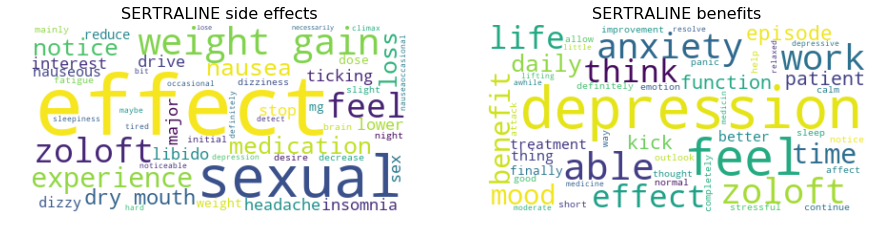

Below analysis based on 2495 reviews for all brand name and generic.
Drug Requested: venlafaxine 
Brand Name(s): ['desvenlafaxine', 'desvenlafaxine succinate', 'effexor', 'effexor xr', 'khedezla', 'pristiq', 'venlafaxine hydrochloride'] 
Generic Name: venlafaxine hydrochloride


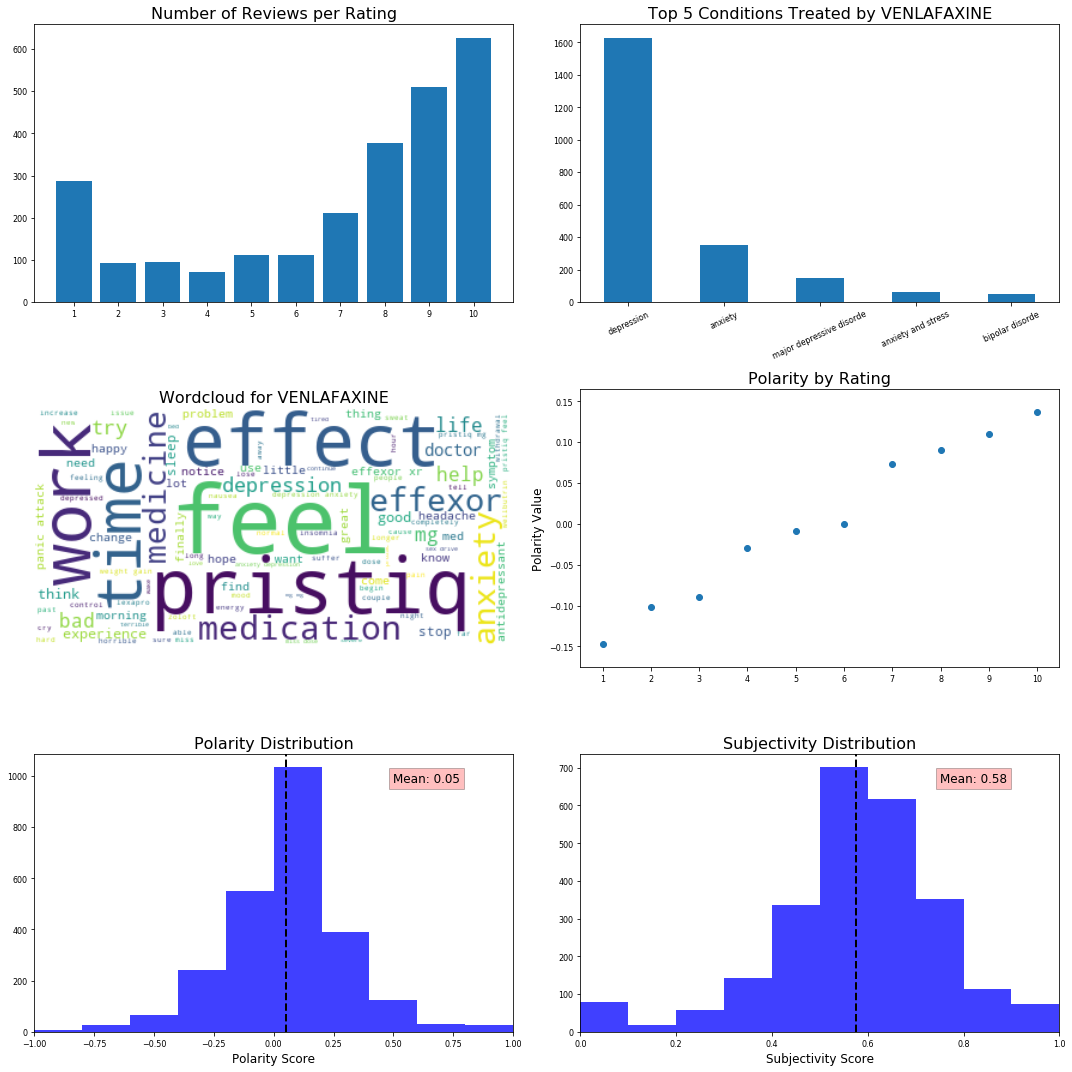

Brand and generic benefits and side effects available for 103 reviews from Drugslib.com


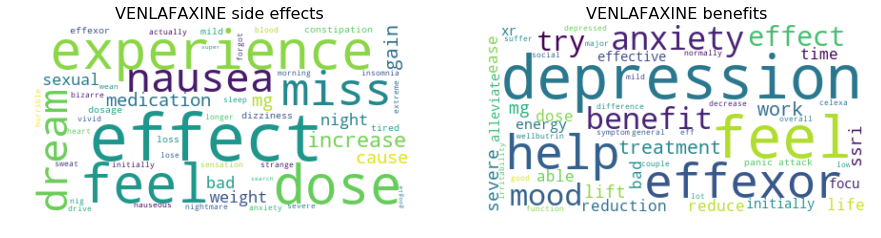

Below analysis based on 1532 reviews for all brand name and generic.
Drug Requested: desvenlafaxine 
Brand Name(s): ['desvenlafaxine', 'desvenlafaxine succinate', 'khedezla', 'pristiq'] 
Generic Name: desvenlafaxine succinate


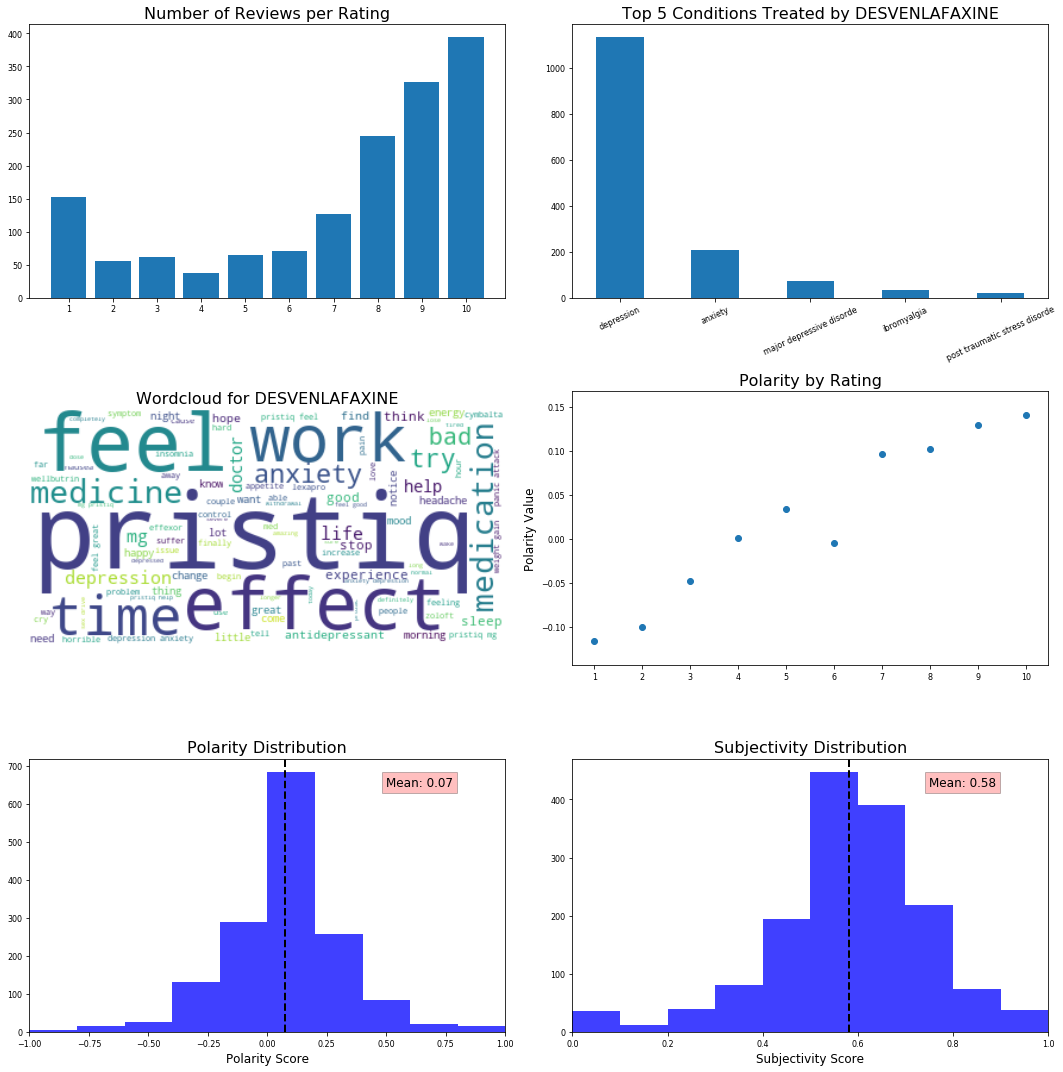

Brand and generic benefits and side effects available for 11 reviews from Drugslib.com


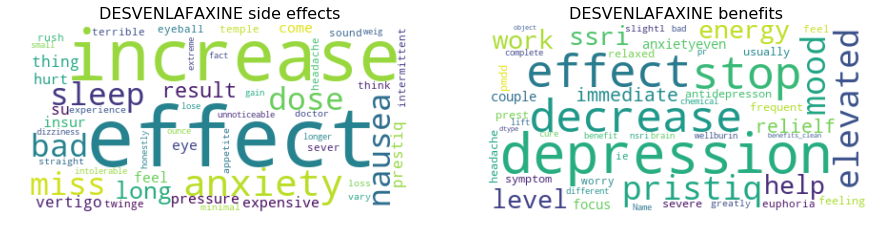

Below analysis based on 739 reviews for all brand name and generic.
Drug Requested: pristiq 
Brand Name(s): ['pristiq'] 
Generic Name: desvenlafaxine succinate


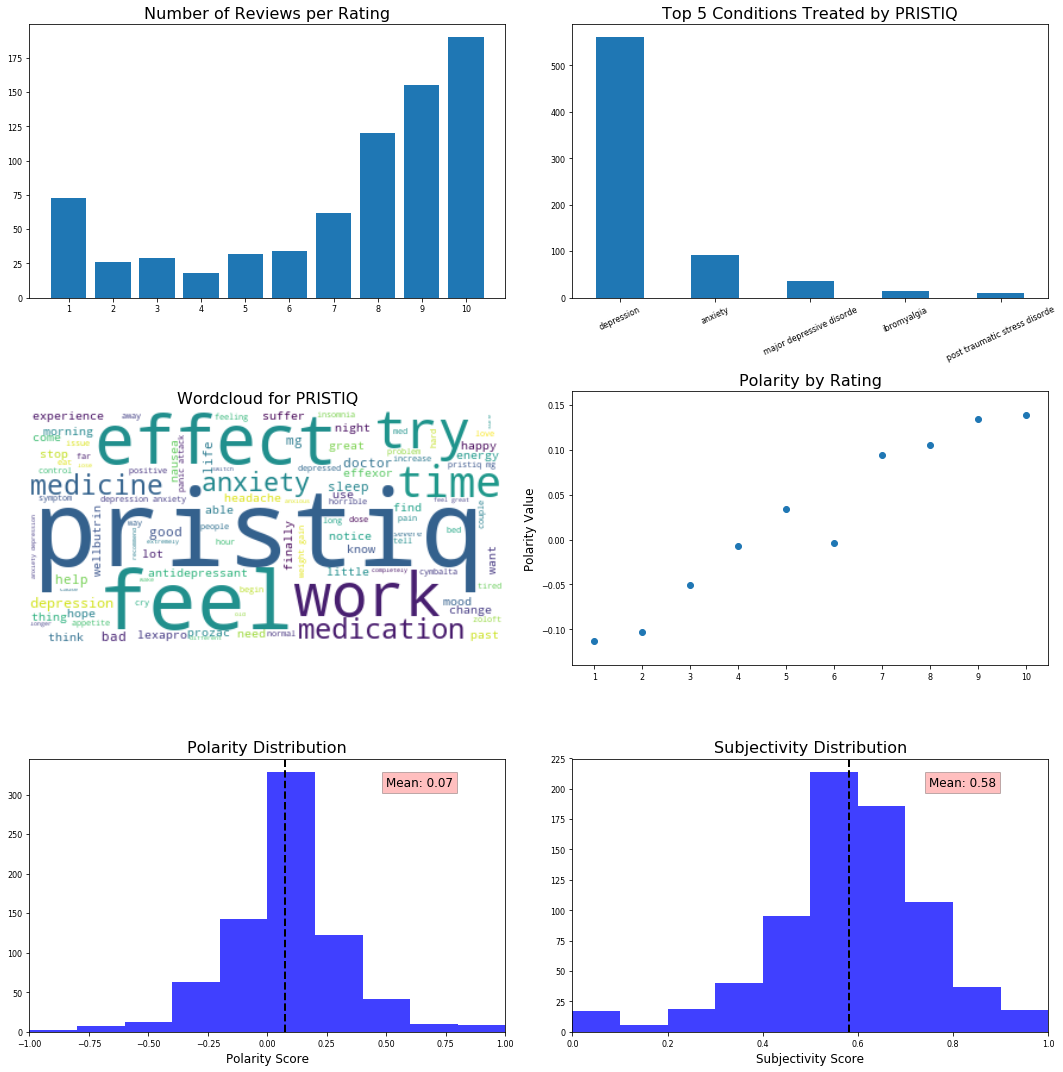

Brand and generic benefits and side effects available for 11 reviews from Drugslib.com


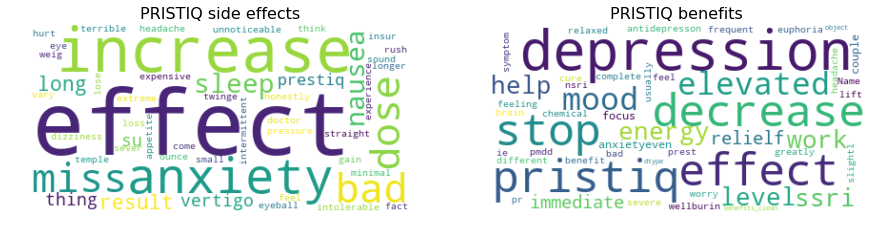

In [24]:
# type in a single condition name into the 'condition' variable and select options as described in the comments
condition = 'depression'
partial_cond_option = 1      # 0 is exact match, 1 is partial wording match
top_n_option = 5             # select how many drugs to show resuts for 
sentiments_only_option = 0   # 0 to show all drug charts, 1 to show only sentiment drug charts

condition_plots(condition, partial_cond_option, top_n_option, sentiments_only_option)

The above charts show the top 5 drugs used to treat depression. Out of those 5 the two with the highest average sentiment scores were Pristiq and Desvenlafaxine. However, in both drugs the wordclouds show that some of the side effects include nausea and a possible increase in anxiety.

Along with these generic EDA charts, any of the above methods of looking for side effects based on negative reviews could be implemented on the entire condition subset of data. 